In [6]:
# Install necessary packages
!pip install scanpy xgboost

# Import necessary libraries
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier

In [3]:
# Set plot style
plt.style.use('dark_background')

# Load the data
adata = sc.read_h5ad('counts.h5ad')
cell_labels = pd.read_csv("https://download.brainimagelibrary.org/cf/1c/cf1c1a431ef8d021/processed_data/cell_labels.csv")

# Explore data shapes
print(f"Data shape (cells x genes): {adata.shape}")
print(f"Number of unique cell types: {cell_labels['class_label'].nunique()}")

# Check the distribution of cell types
print(cell_labels['class_label'].value_counts())

# Extract expression matrix and class labels
X = pd.DataFrame(adata.X)  # Convert sparse matrix to dense format
y = cell_labels['class_label'].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

Data shape (cells x genes): (280186, 254)
Number of unique cell types: 3
class_label
Glutamatergic    155831
Other            106055
GABAergic         18300
Name: count, dtype: int64


In [7]:
X
device = "cuda" if torch.cuda.is_available()else "cpu"

In [9]:
# Define the XGBoost classifier
# Hyperparameters were selected by Optuna
xgb_model = XGBClassifier(
    learning_rate= 0.056024437948936294,
    n_estimators= 991,
    max_depth= 6,
    min_child_weight= 7,
    subsample= 0.8648223296580454,
    colsample_bytree= 0.784429554949425,
    reg_alpha= 0.0070581139949886795,
    reg_lambda= 0.42629746370575733,
    tree_method='gpu_hist',
    random_state=2
)

# Train the model
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:08:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.784429554949425, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.056024437948936294,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=991, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [10]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:10:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:10:04] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [11]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9980
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3660
           1       1.00      1.00      1.00     31167
           2       1.00      1.00      1.00     21211

    accuracy                           1.00     56038
   macro avg       1.00      1.00      1.00     56038
weighted avg       1.00      1.00      1.00     56038



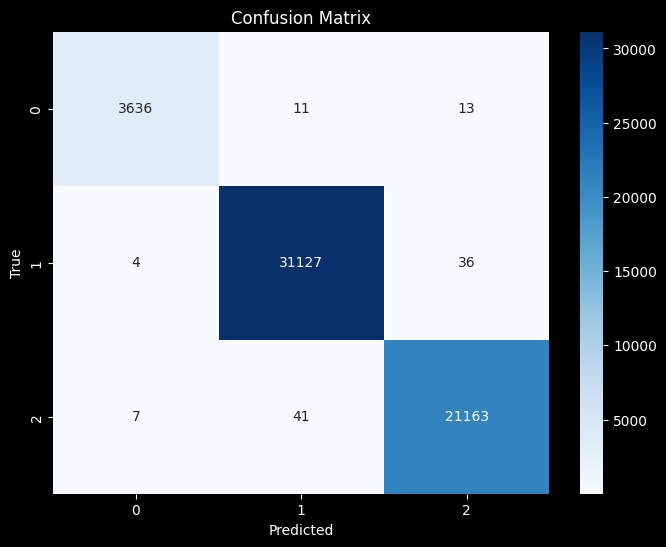

In [12]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()